In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import accuracy_score, mean_absolute_error
import os

from ssl_eeg import preprocessing as pr, preprocessing_nback as prn, model, prediction as prd, plot, head
from ssl_eeg.train_sl import device

models_doc = pd.read_csv(model.models_doc_path, index_col=0)
models_conf = pd.read_csv(model.models_conf_path, index_col=0)
models_doc_head = pd.read_csv(model.models_doc_head_path, index_col=0)
models_conf_head = pd.read_csv(model.models_conf_head_path, index_col=0)

/home/jeusa/anaconda3/envs/ba/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device is: cuda:0


In [2]:
models_hb = models_doc_head.join(models_doc, lsuffix="_head", on="base_model")
compare_metrics = ["test_acc", "test_acc_head", "test_mae", "test_mae_head"]
models_hb = models_hb.join(models_conf["filter"], on="conf_id")

sl_conf_ids = models_conf.loc[models_conf["supervised"]=="supervised"].index
ssl_conf_ids = models_conf.loc[models_conf["supervised"]=="self-supervised"].index
sl_models = models_doc.loc[models_doc["conf_id"].isin(sl_conf_ids)]
ssl_models = models_doc.loc[models_doc["conf_id"].isin(ssl_conf_ids)]

### Supervised encoders

In [3]:
sl_head = models_hb.loc[models_hb["base_model"].isin(sl_models.index)]
sl_head_45 = sl_head.loc[sl_head["filter"]==45]
sl_head_55 = sl_head.loc[sl_head["filter"]==55]
sl_head

,conf_id_head,base_model,model_name_head,date_time_head,train_loss_head,val_loss_head,epochs_head,val_fold_idx,val_acc_head,test_acc_head,...,triplet_val_acc,test_acc,triplet_test_acc,test_pool_acc,val_pool_acc,test_mae,val_mae,test_pool_mae,val_pool_mae,filter
model_id,,,,,,,,,,,,,,,,,,,,,
239,1,199,head_conf_id_1_model_1,04-12-2023_13:18:18,0.867485,0.994279,15,0,0.509346,0.257022,...,0.721431,0.279494,0.509252,0.514045,0.841121,1.398876,0.481308,0.485955,0.158879,45
240,1,200,head_conf_id_1_model_2,04-12-2023_13:18:24,0.791753,0.990449,15,1,0.546729,0.264045,...,0.703898,0.255618,0.517100,0.530899,0.836449,1.167135,0.509346,0.469101,0.163551,45
241,2,205,head_conf_id_2_model_1,04-12-2023_13:39:45,0.440651,0.542089,15,0,0.714953,0.250000,...,0.815682,0.250000,0.581857,0.500000,0.925234,1.000000,0.280374,0.500000,0.074766,55
242,2,206,head_conf_id_2_model_2,04-12-2023_13:39:50,0.412175,0.541741,15,1,0.775701,0.250000,...,0.827875,0.250000,0.604274,0.500000,0.957944,1.500000,0.261682,0.500000,0.042056,55
243,3,207,head_conf_id_3_model_1,04-12-2023_13:39:59,0.892718,1.082806,15,0,0.485981,0.435393,...,0.659815,0.383427,0.589078,0.688202,0.766355,0.879213,0.640187,0.311798,0.233645,45
244,3,208,head_conf_id_3_model_2,04-12-2023_13:40:04,0.946006,1.051632,15,1,0.490654,0.297753,...,0.670493,0.292135,0.632864,0.515449,0.789720,1.199438,0.644860,0.484551,0.210280,45
245,4,233,head_conf_id_4_model_1,04-12-2023_13:40:13,0.556414,0.609960,15,0,0.686916,0.250000,...,0.752002,0.250000,0.568844,0.500000,0.808411,1.000000,0.476636,0.500000,0.191589,55
246,4,234,head_conf_id_4_model_2,04-12-2023_13:40:19,0.397803,0.542063,15,1,0.817757,0.250000,...,0.819452,0.255618,0.522646,0.505618,0.873832,0.991573,0.364486,0.494382,0.126168,55


In [4]:
print("45Hz:")
print("mean")
display(sl_head_45[compare_metrics].mean().round(3))
print("std")
display(sl_head_45[compare_metrics].std().round(3))

45Hz:
mean


test_acc         0.303
test_acc_head    0.314
test_mae         1.161
test_mae_head    1.171
dtype: float64

std


test_acc         0.056
test_acc_head    0.083
test_mae         0.214
test_mae_head    0.250
dtype: float64

In [5]:
print("55Hz:")
print("mean")
display(sl_head_55[compare_metrics].mean().round(3))
print("std")
display(sl_head_55[compare_metrics].std().round(3))

55Hz:
mean


test_acc         0.251
test_acc_head    0.250
test_mae         1.123
test_mae_head    1.000
dtype: float64

std


test_acc         0.003
test_acc_head    0.000
test_mae         0.251
test_mae_head    0.000
dtype: float64

Loading loss of head_conf_id_1_model_1
Loading loss of head_conf_id_1_model_2


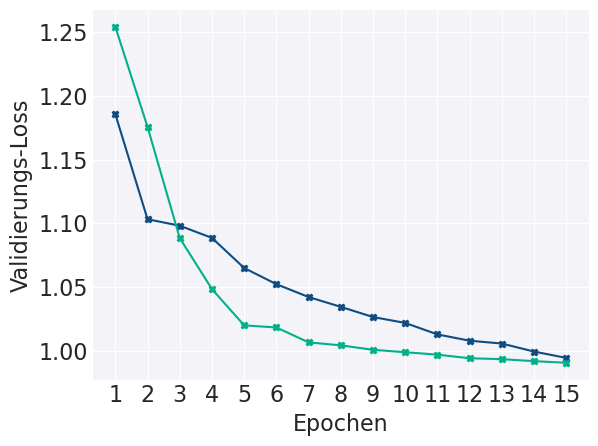

In [6]:
mpl.rcParams["font.size"] = 16
f1 = plot.plot_metrics(conf_ids=[1], metric_key="val_loss", head=True, show_legend=False, y_title=None)
# f1.savefig(os.path.join(plot.plots_path, "val_loss_conf_id_1_head_45Hz_sl.png"), dpi=200, bbox_inches="tight")

### Self-supervised encoders

In [7]:
ssl_head = models_hb.loc[models_hb["base_model"].isin(ssl_models.index)]
ssl_head

,conf_id_head,base_model,model_name_head,date_time_head,train_loss_head,val_loss_head,epochs_head,val_fold_idx,val_acc_head,test_acc_head,...,triplet_val_acc,test_acc,triplet_test_acc,test_pool_acc,val_pool_acc,test_mae,val_mae,test_pool_mae,val_pool_mae,filter
model_id,,,,,,,,,,,,,,,,,,,,,
247,5,193,head_conf_id_5_model_1,04-12-2023_13:40:28,2.485064,2.820650,15,0,0.219626,0.224719,...,0.961049,0.228230,0.964888,0.479986,NaN,1.288624,NaN,0.520014,NaN,45
248,5,193,head_conf_id_5_model_2,04-12-2023_13:40:33,2.439621,2.900036,15,1,0.238318,0.240169,...,0.961049,0.228230,0.964888,0.479986,NaN,1.288624,NaN,0.520014,NaN,45
249,6,194,head_conf_id_6_model_1,04-12-2023_13:40:42,2.449801,2.737341,15,0,0.266355,0.241573,...,0.974571,0.229986,0.963132,0.481390,NaN,1.265801,NaN,0.518610,NaN,45
250,6,194,head_conf_id_6_model_2,04-12-2023_13:40:47,2.480480,2.816995,15,1,0.219626,0.275281,...,0.974571,0.229986,0.963132,0.481390,NaN,1.265801,NaN,0.518610,NaN,45
251,7,195,head_conf_id_7_model_1,04-12-2023_13:40:56,1.890254,2.065950,15,0,0.275701,0.262640,...,0.937578,0.245435,0.927669,0.490520,NaN,1.251404,NaN,0.509480,NaN,45
252,7,195,head_conf_id_7_model_2,04-12-2023_13:41:02,1.958082,2.570600,15,1,0.214953,0.237360,...,0.937578,0.245435,0.927669,0.490520,NaN,1.251404,NaN,0.509480,NaN,45
253,8,196,head_conf_id_8_model_1,04-12-2023_13:41:10,1.830678,2.317245,15,0,0.242991,0.231742,...,0.958374,0.237360,0.928371,0.500702,NaN,1.259129,NaN,0.499298,NaN,45
254,8,196,head_conf_id_8_model_2,04-12-2023_13:41:16,1.960397,2.326296,15,1,0.317757,0.262640,...,0.958374,0.237360,0.928371,0.500702,NaN,1.259129,NaN,0.499298,NaN,45
255,9,197,head_conf_id_9_model_1,04-12-2023_13:41:25,1.390493,1.477660,15,0,0.266355,0.259831,...,0.866916,0.245084,0.826194,0.498947,NaN,1.265801,NaN,0.501053,NaN,45


In [8]:
ssl_head_45 = ssl_head.loc[ssl_head["filter"]==45]
ssl_head_55 = ssl_head.loc[ssl_head["filter"]==55]

In [16]:
print("45Hz:")
print("mean")
display(ssl_head_45[compare_metrics].mean().round(3))
print("std")
display(ssl_head_45[compare_metrics].std().round(3))

45Hz:
mean


test_acc         0.237
test_acc_head    0.249
test_mae         1.272
test_mae_head    1.260
dtype: float64

std


test_acc         0.007
test_acc_head    0.015
test_mae         0.017
test_mae_head    0.044
dtype: float64

Loading loss of head_conf_id_5_model_1
Loading loss of head_conf_id_5_model_2
Loading loss of head_conf_id_6_model_1
Loading loss of head_conf_id_6_model_2


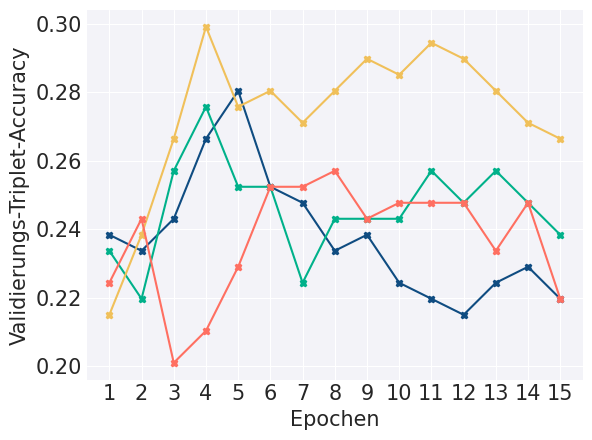

In [7]:
f1 = plot.plot_metrics(conf_ids=list(range(5, 7)), metric_key="val_acc", head=True, show_legend=False)

In [18]:
print("55Hz:")
print("mean")
display(ssl_head_55[compare_metrics].mean().round(3))
print("std")
display(ssl_head_55[compare_metrics].std().round(3))

55Hz:
mean


test_acc         0.250
test_acc_head    0.261
test_mae         1.231
test_mae_head    1.207
dtype: float64

std


test_acc         0.007
test_acc_head    0.028
test_mae         0.015
test_mae_head    0.032
dtype: float64

### Accuracy calculation

head_conf_id_1_model_1
conf_id_114_model_1
head_conf_id_1_model_2
conf_id_114_model_2
head_conf_id_2_model_1
conf_id_117_model_1
head_conf_id_2_model_2
conf_id_117_model_2
head_conf_id_3_model_1
conf_id_118_model_1
head_conf_id_3_model_2
conf_id_118_model_2
head_conf_id_4_model_1
conf_id_131_model_1
head_conf_id_4_model_2
conf_id_131_model_2
head_conf_id_5_model_1
conf_id_111_model_1_ssl
head_conf_id_5_model_2
conf_id_111_model_3_ssl
head_conf_id_6_model_1
conf_id_111_model_1_ssl


/home/jeusa/anaconda3/envs/ba/lib/python3.8/site-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


head_conf_id_6_model_2
conf_id_111_model_3_ssl
head_conf_id_7_model_1
conf_id_112_model_1_ssl
head_conf_id_7_model_2
conf_id_112_model_3_ssl
head_conf_id_8_model_1
conf_id_112_model_1_ssl
head_conf_id_8_model_2
conf_id_112_model_3_ssl
head_conf_id_9_model_1
conf_id_113_model_1_ssl
head_conf_id_9_model_2
conf_id_113_model_3_ssl
head_conf_id_10_model_1
conf_id_113_model_1_ssl
head_conf_id_10_model_2
conf_id_113_model_3_ssl
head_conf_id_11_model_1
conf_id_128_model_1_ssl
head_conf_id_11_model_2
conf_id_128_model_3_ssl
head_conf_id_12_model_1
conf_id_128_model_1_ssl
head_conf_id_12_model_2
conf_id_128_model_3_ssl
head_conf_id_13_model_1
conf_id_129_model_1_ssl
head_conf_id_13_model_2
conf_id_129_model_3_ssl
head_conf_id_14_model_1
conf_id_129_model_1_ssl
head_conf_id_14_model_2
conf_id_129_model_3_ssl
head_conf_id_15_model_1
conf_id_130_model_1_ssl
head_conf_id_15_model_2
conf_id_130_model_3_ssl
head_conf_id_16_model_1
conf_id_130_model_1_ssl
head_conf_id_16_model_2
conf_id_130_model_3_ssl

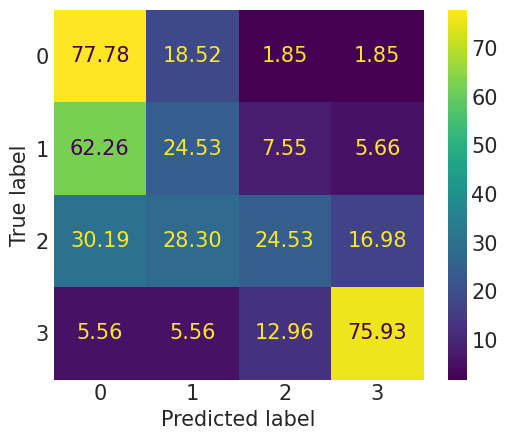

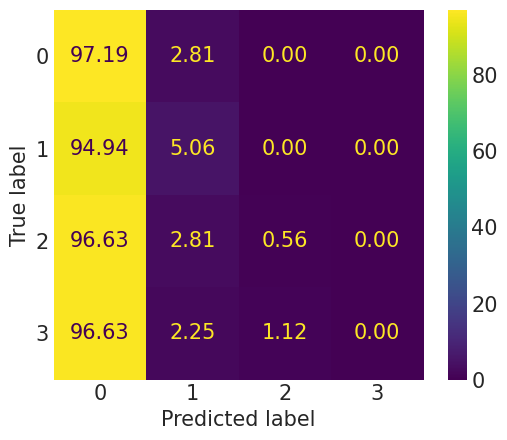

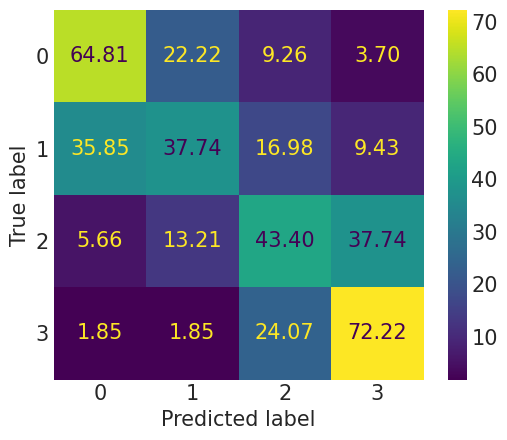

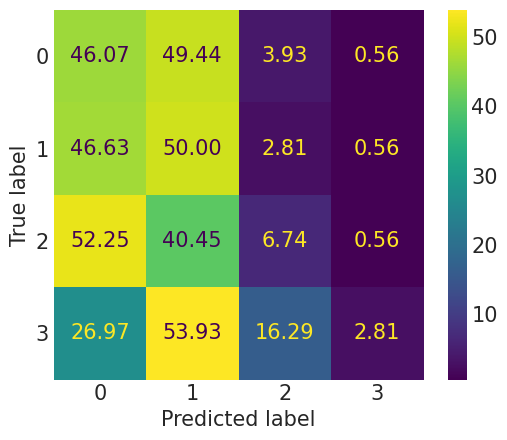

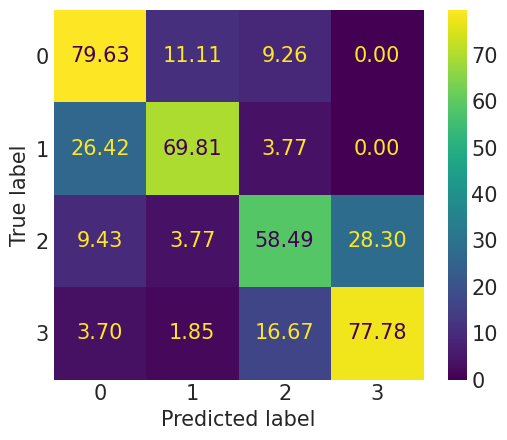

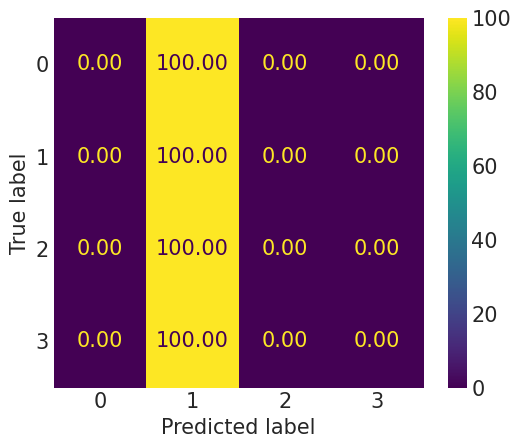

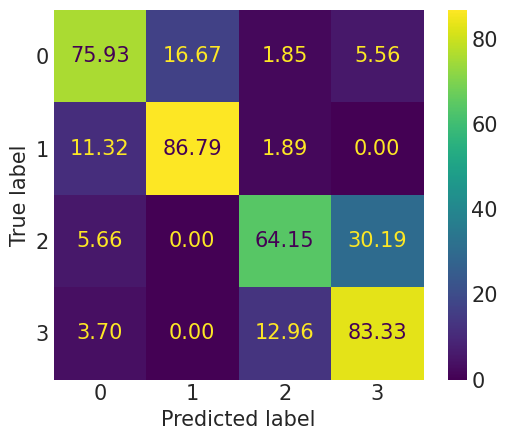

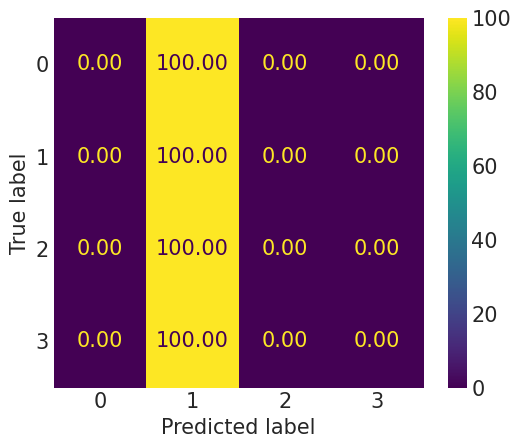

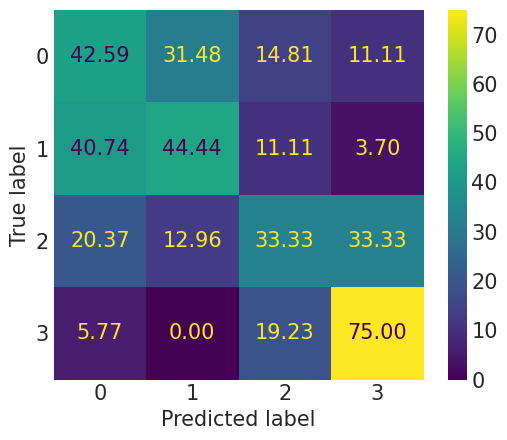

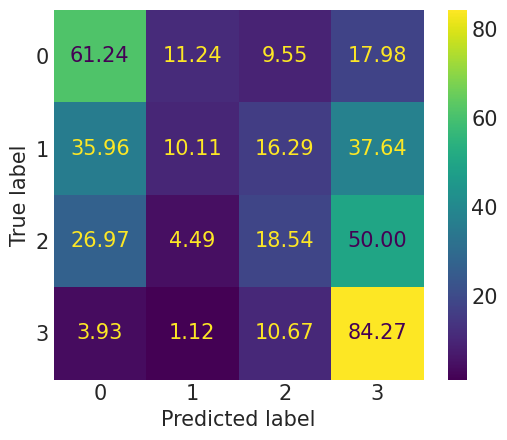

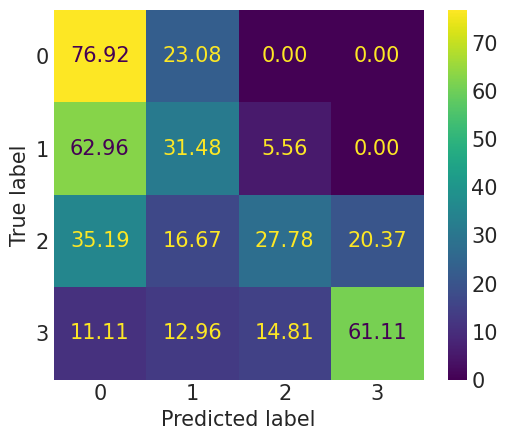

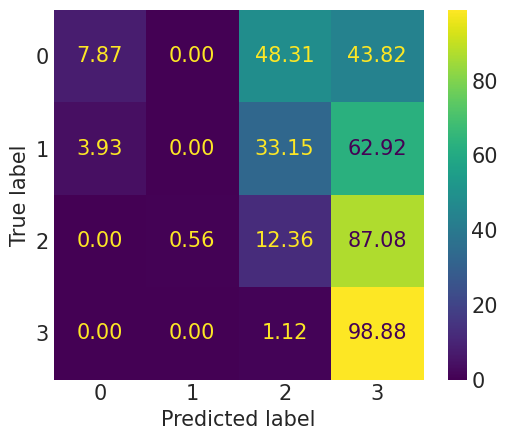

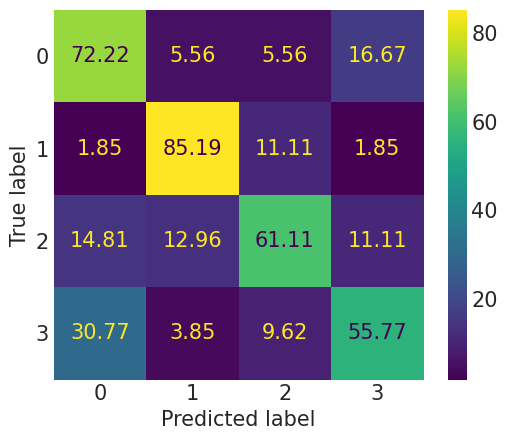

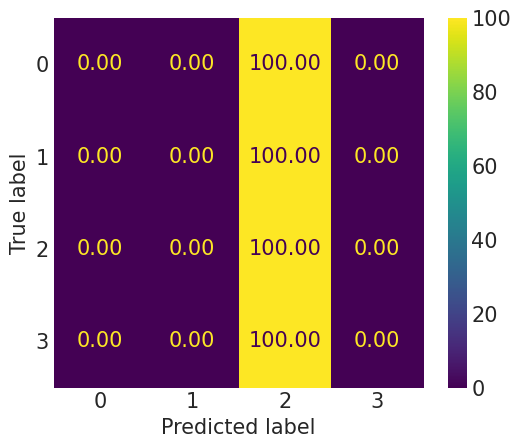

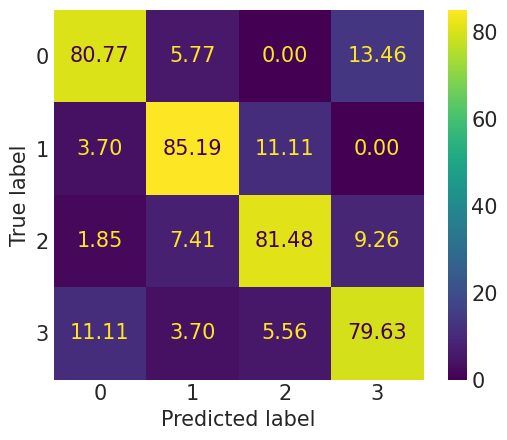

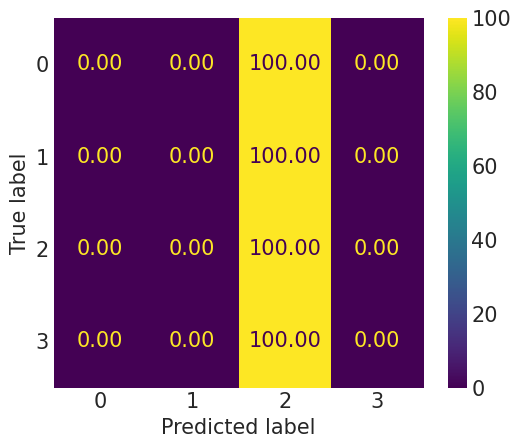

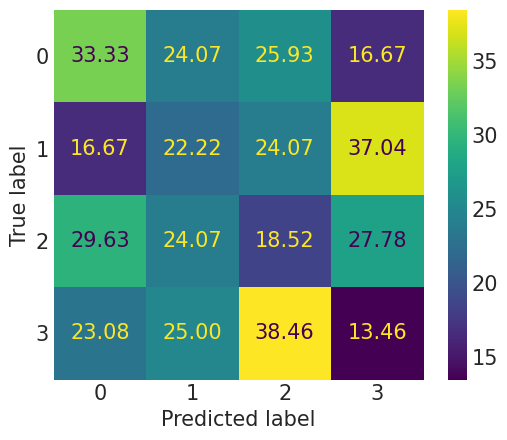

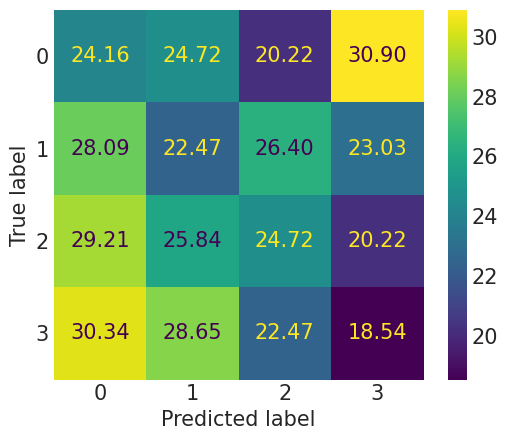

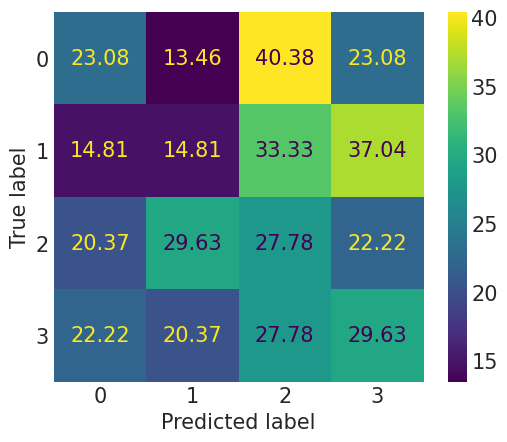

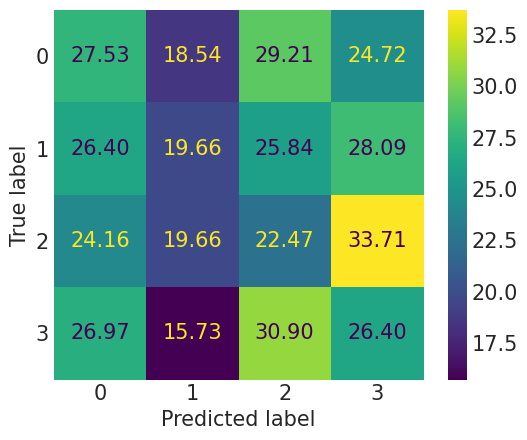

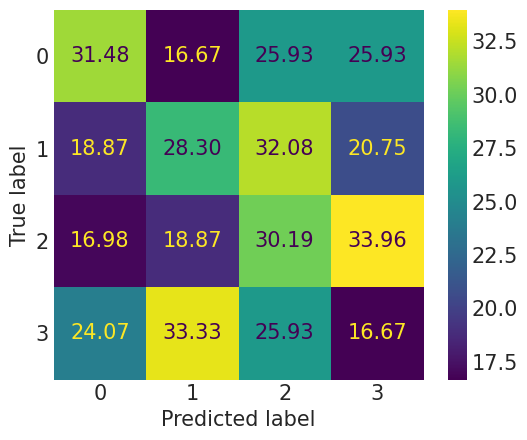

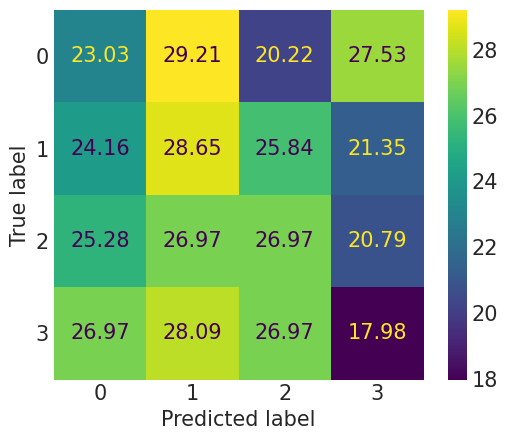

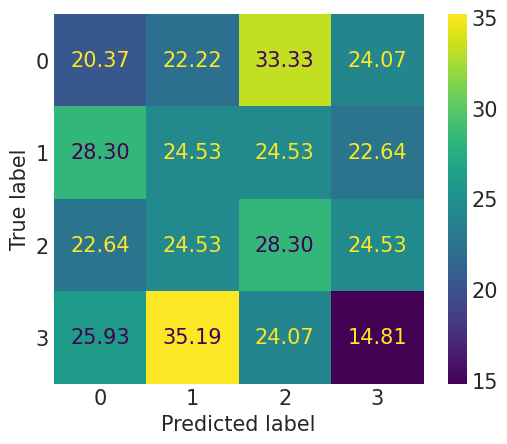

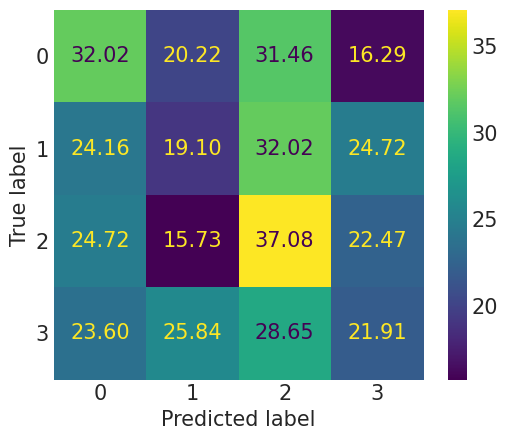

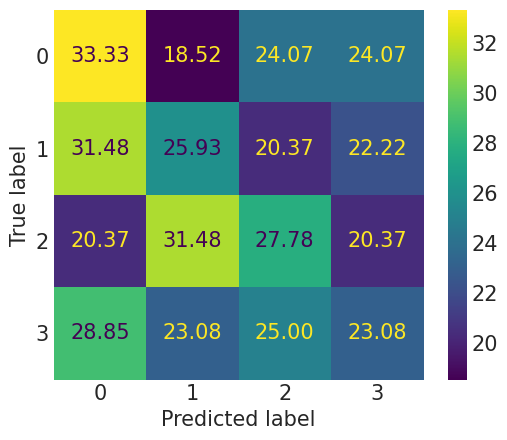

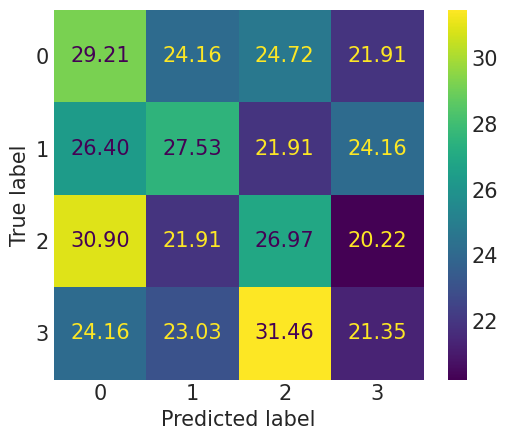

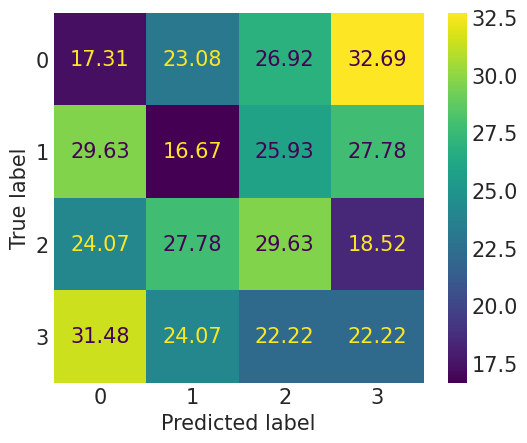

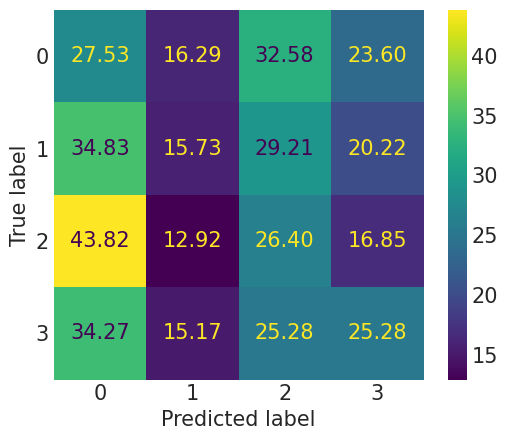

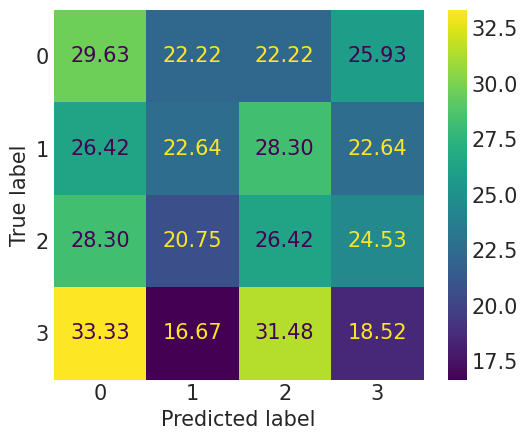

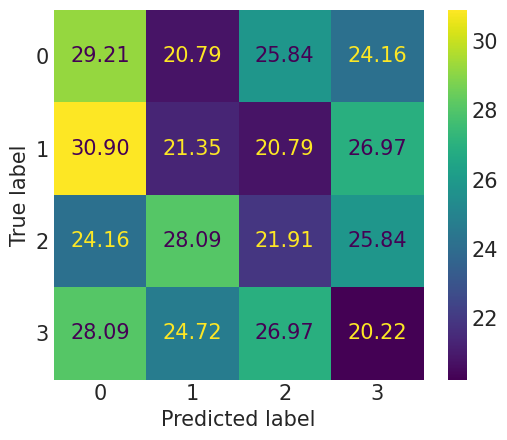

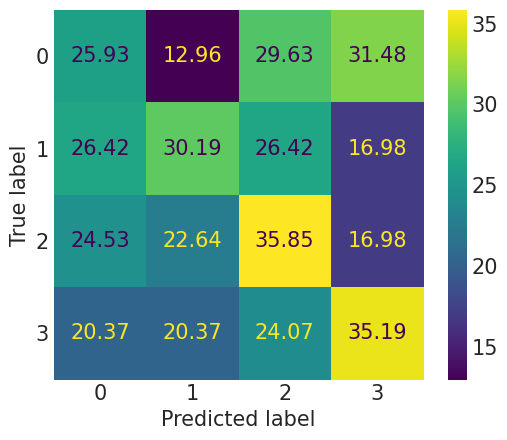

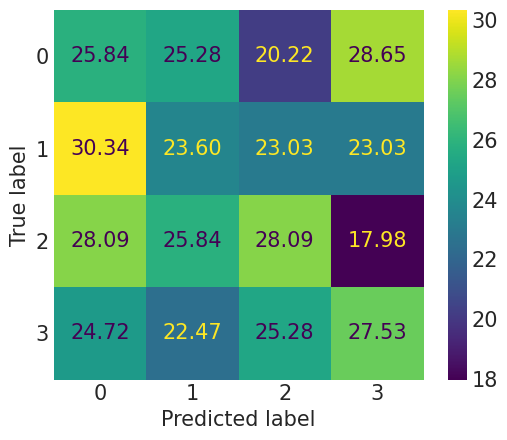

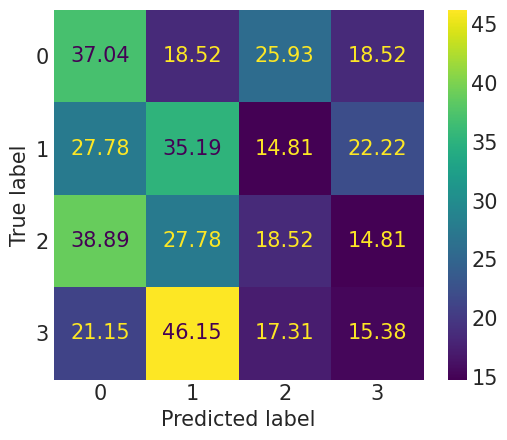

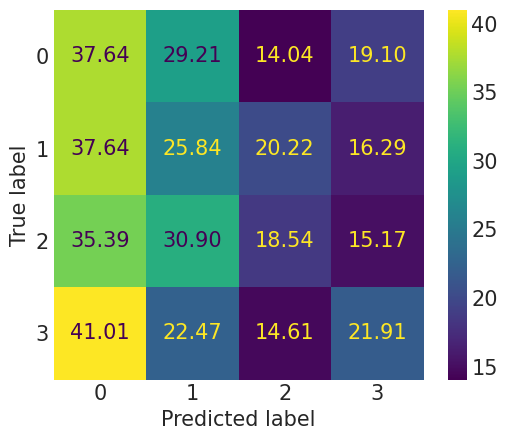

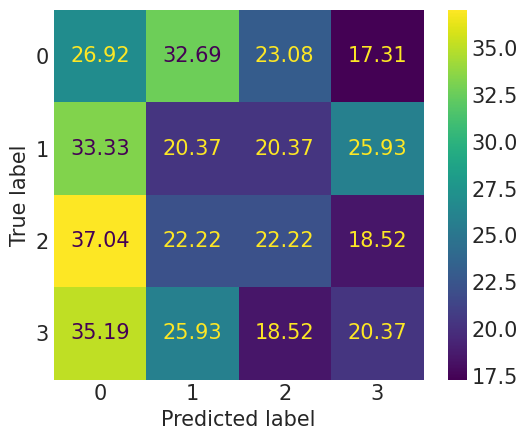

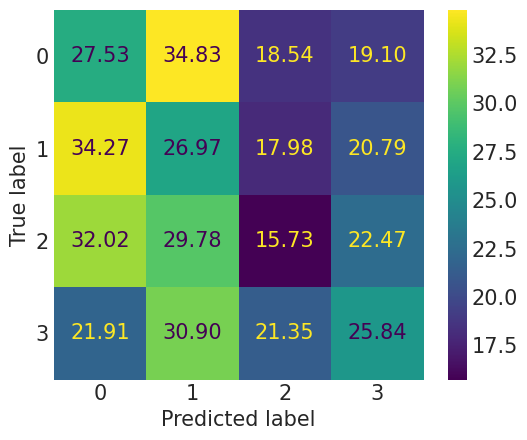

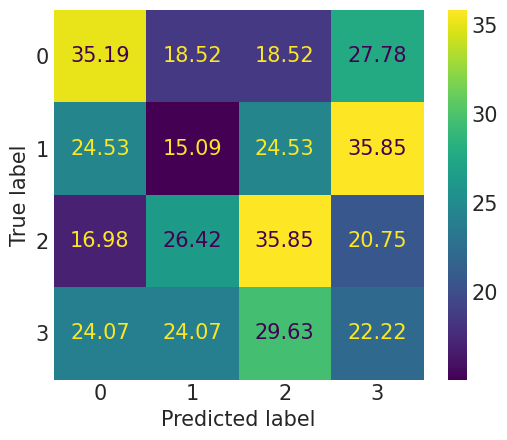

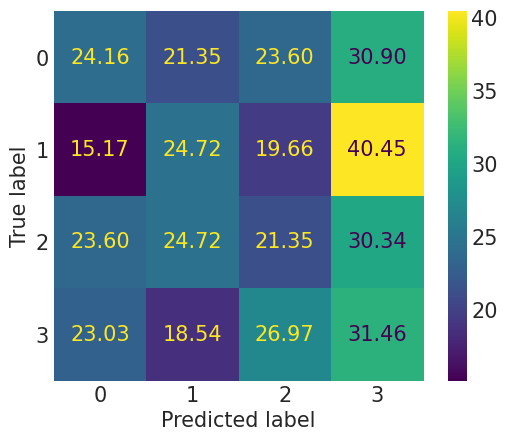

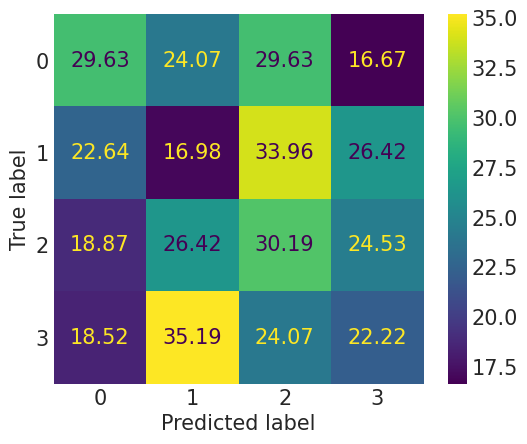

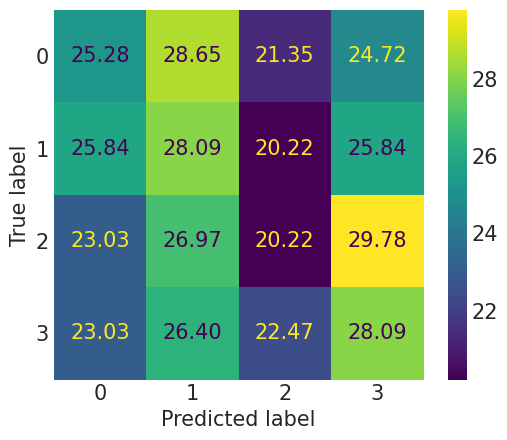

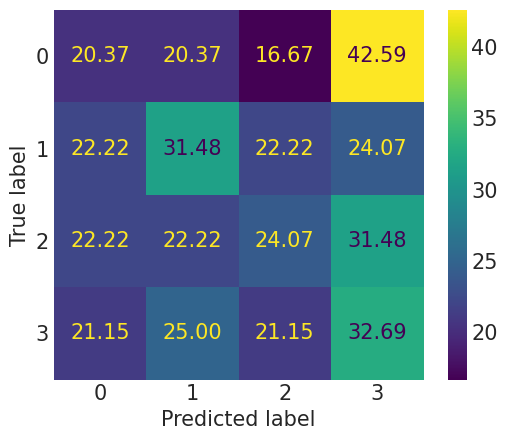

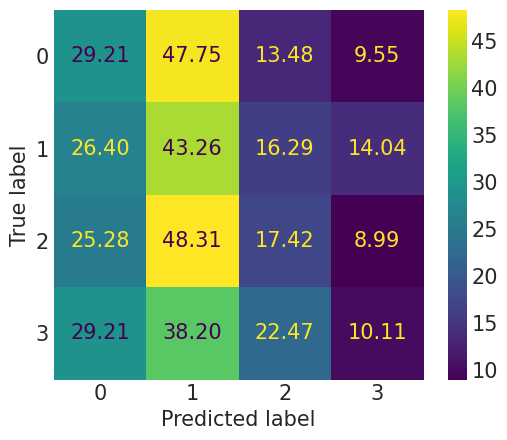

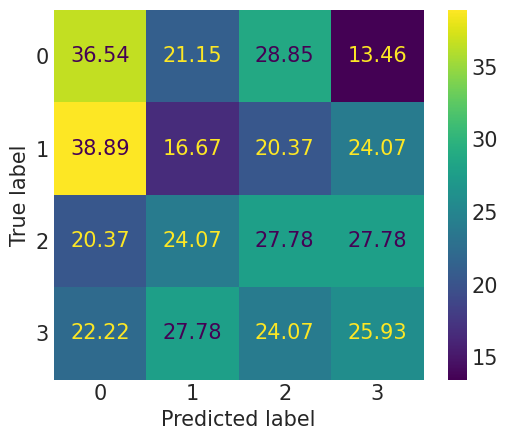

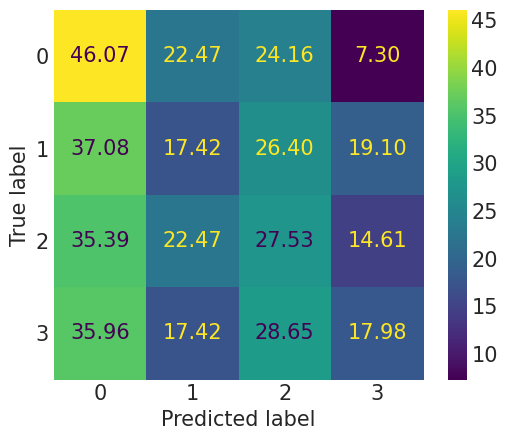

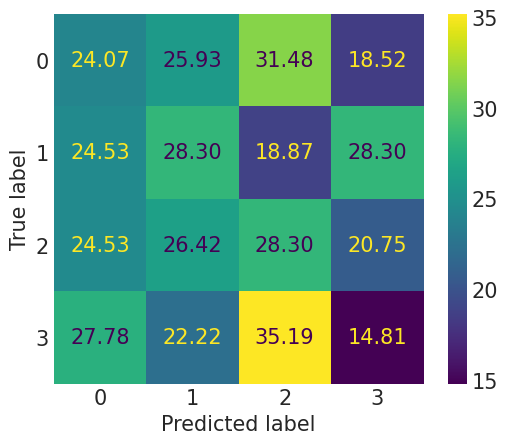

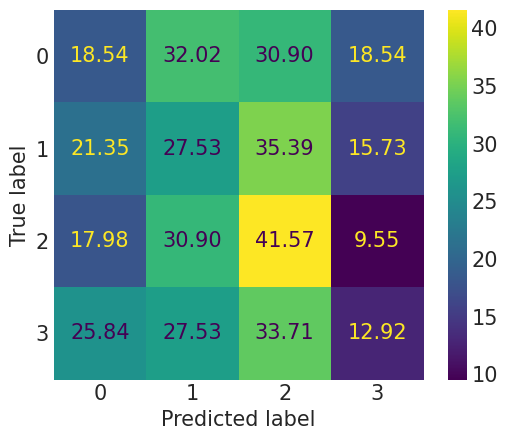

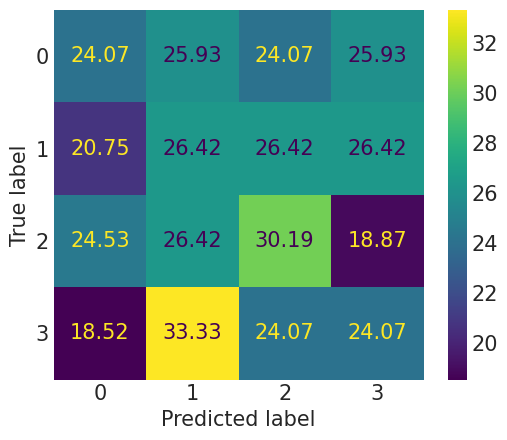

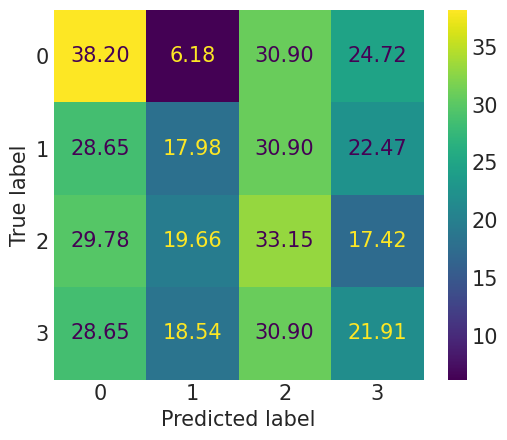

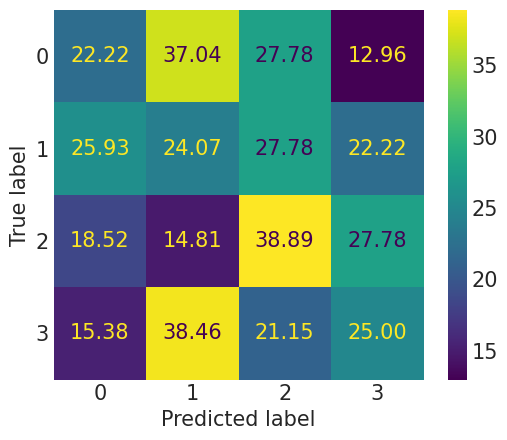

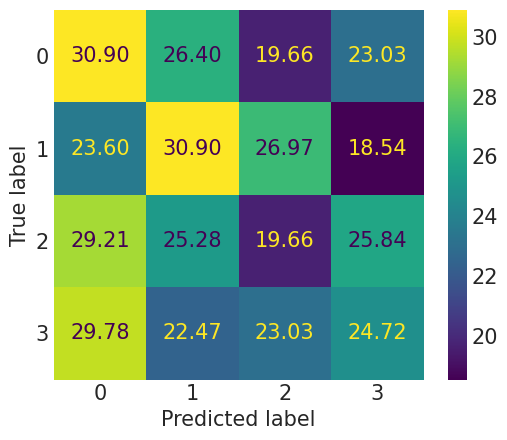

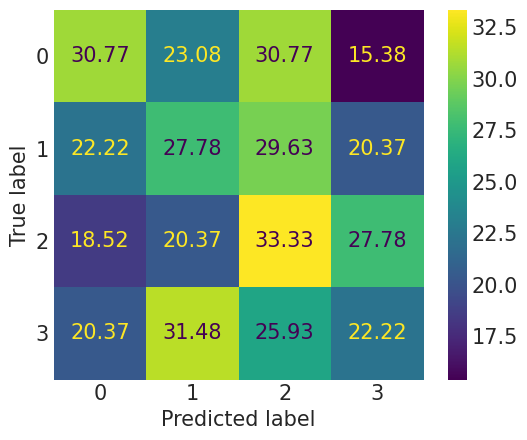

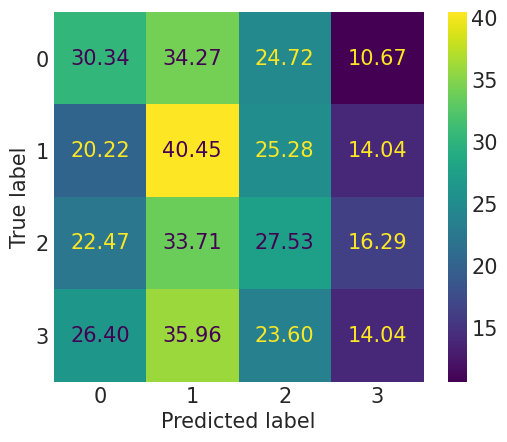

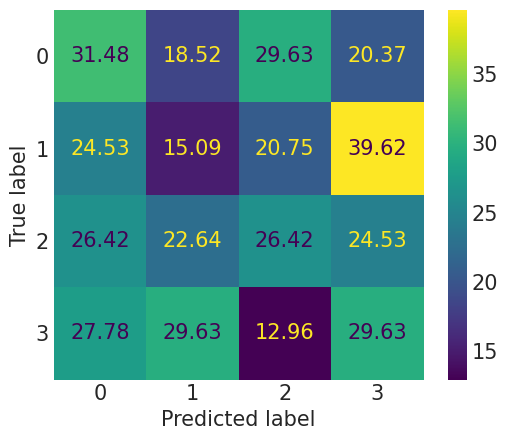

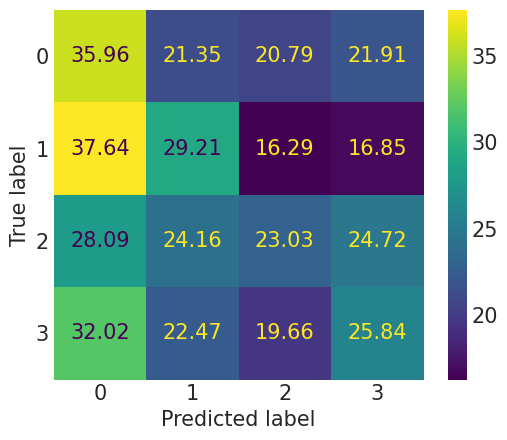

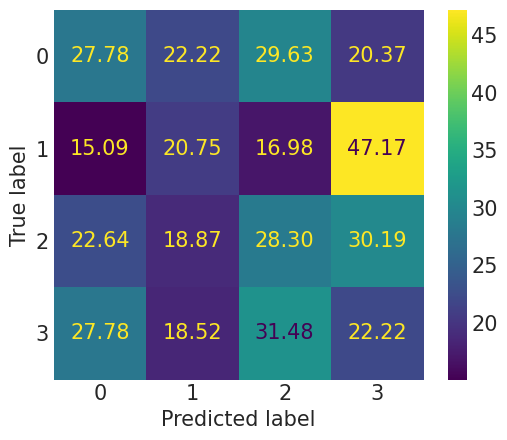

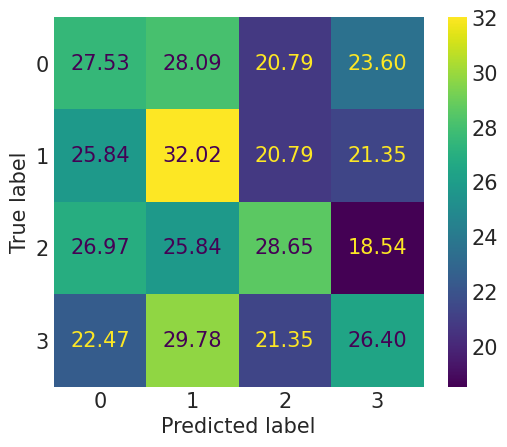

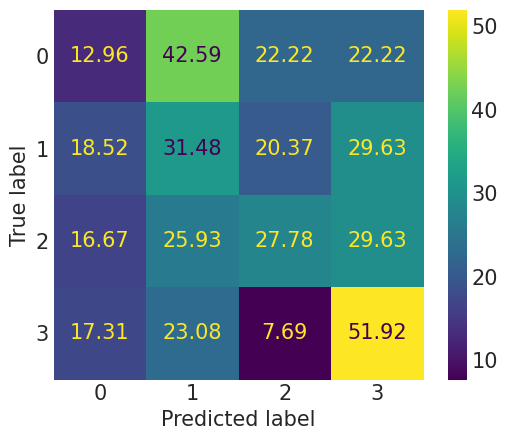

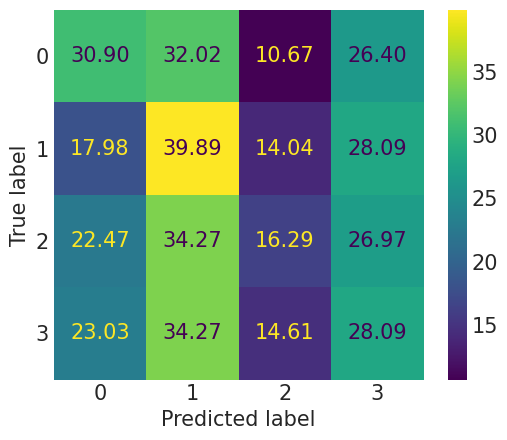

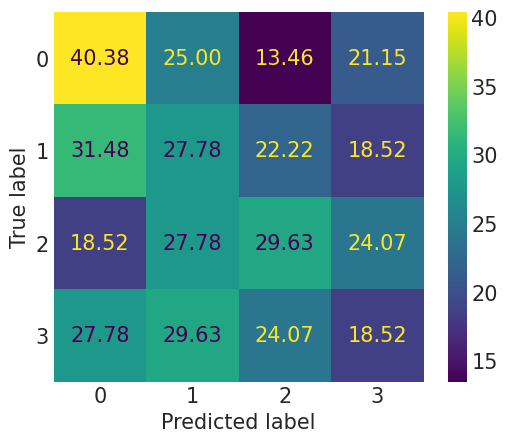

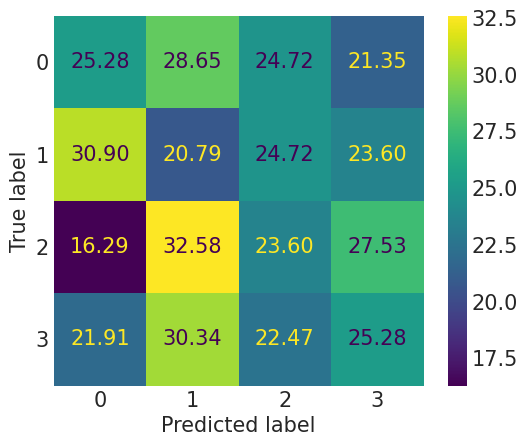

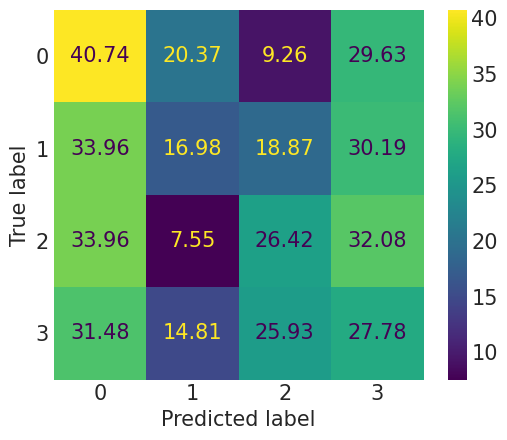

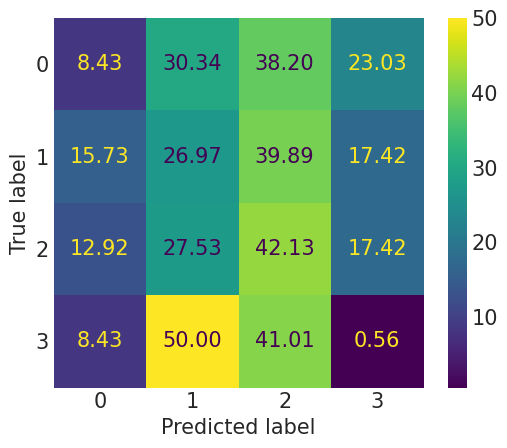

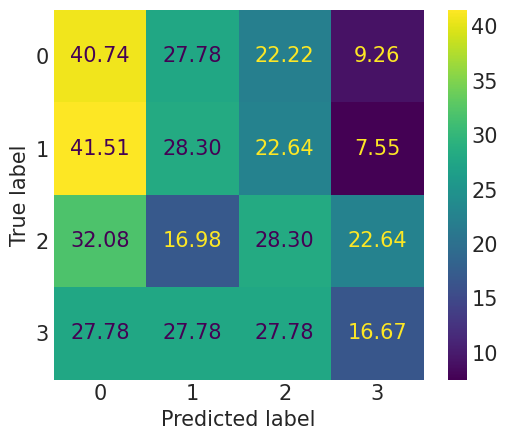

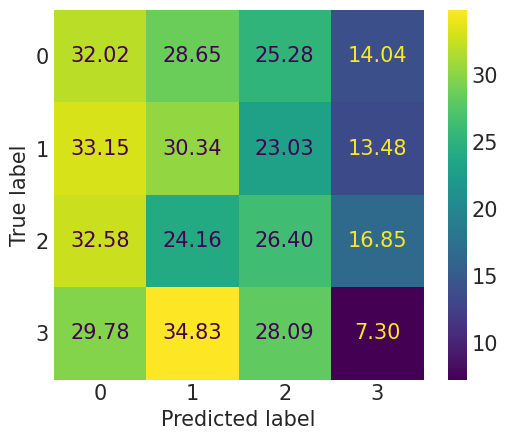

In [16]:
# calculate classification accuracy on n-back data
calc_acc = False
calc_mae = False
make_conf_mx = True
save_conf_mx = True
german = False

if german:
    lan_txt = ""
else:
    lan_txt = "_en"

for i, cur_mo in models_doc_head.iterrows():
    print(cur_mo["model_name"])
    v_i = cur_mo["val_fold_idx"]

    cur_conf = models_conf_head.loc[cur_mo["conf_id"]]
    base_conf = models_conf.loc[cur_conf["base_model_conf"]]

    base_model = models_doc.loc[models_doc["conf_id"]==base_conf.name].iloc[v_i]
    base_name = base_model["model_name"]
    print(base_name)

    # base and head models
    base_model = model.load_model(base_name + "_best_val", out_dim=base_conf["out_dim"], dropout_p=base_conf["dropout_p"])
    head_model = model.load_head_model(cur_mo["model_name"] + "_best_val", in_dim=base_conf["out_dim"])

    # n-back data
    blocks_df, chunks = prn.arange_data(filter_data=True, lowpass=base_conf["filter"], trans_band_auto=False, verbose=False)

    if base_conf["supervised"] == "supervised":
        test_ses = base_conf["test_session"]
    else:
        test_ses = cur_conf["test_session"]

    train_chunks, test_chunks = prn.get_train_test_sets(chunks, test_session=test_ses)

    folds = pr.get_folds(train_chunks, k_folds=10)
    train_set, val_set = pr.get_train_val_sets(folds, v_i)

    # feature representation of data, output of base model
    train_features, train_y = prd.get_model_output_n(base_model, train_set, blocks_df, as_df=False)
    train_y = train_y.to(torch.long)
    train_y = train_y.to(device)

    val_features, val_y = prd.get_model_output_n(base_model, val_set, blocks_df, as_df=False)
    val_y = val_y.to(torch.long)
    val_y = val_y.to(device)

    test_features, test_y = prd.get_model_output_n(base_model, test_chunks, blocks_df, as_df=False)
    test_y = test_y.to(torch.long)
    test_y = test_y.to(device)

    # predictions
    val_pred = head.make_predictions(head_model, val_features)
    test_pred = head.make_predictions(head_model, test_features)

    # calc accuracies
    if calc_acc:
        val_acc = accuracy_score(val_y.cpu(), val_pred.cpu())
        test_acc = accuracy_score(test_y.cpu(), test_pred.cpu())
        print(val_acc, test_acc)

        models_doc_head.loc[i, ["val_acc", "test_acc"]] = [val_acc, test_acc]

    # mae
    if calc_mae:
        val_mae = mean_absolute_error(val_y.cpu(), val_pred.cpu())
        test_mae = mean_absolute_error(test_y.cpu(), test_pred.cpu())
        print(val_mae, test_mae)

        models_doc_head.loc[i, ["val_mae", "test_mae"]] = [val_mae, test_mae]

    # confusion matrix
    if make_conf_mx:
        supervised_txt = "sl"
        if base_conf["supervised"] == "self-supervised":
            supervised_txt = "ssl"

        cm, disp = plot.plot_conf_matrix(labels_true=val_y.cpu(), labels_pred=val_pred.cpu(), german=german)
        if save_conf_mx:
            plt.savefig(os.path.join(plot.conf_matrix_path, "head", base_conf["supervised"], f"confusion_matrix_val_conf_id_{cur_conf.name}_model_{v_i+1}_{supervised_txt}_test_ses_{int(cur_conf['test_session'])}_head{lan_txt}"), dpi=200, bbox_inches="tight")

        cm, disp = plot.plot_conf_matrix(labels_true=test_y.cpu(), labels_pred=test_pred.cpu(), german=german)
        if save_conf_mx:
            plt.savefig(os.path.join(plot.conf_matrix_path, "head", base_conf["supervised"], f"confusion_matrix_test_conf_id_{cur_conf.name}_model_{v_i+1}_{supervised_txt}_test_ses_{int(cur_conf['test_session'])}_head{lan_txt}"), dpi=200, bbox_inches="tight")

In [23]:
# calculate mean values for loss and accuracies
for c_id, frame in models_doc_head.groupby("conf_id"):
    m = frame[["val_loss", "train_loss"]].mean(axis=0)
    v = frame[["val_loss", "train_loss"]].std(axis=0)
    models_conf_head.loc[c_id, ["mean_val_loss", "mean_train_loss", "std_val_loss", "std_train_loss"]] = [m["val_loss"], m["train_loss"], v["val_loss"], v["train_loss"]]
    
    m = frame[["val_acc"]].mean(axis=0)
    v = frame[["val_acc"]].std(axis=0)
    models_conf_head.loc[c_id, ["mean_val_acc", "std_val_acc"]] = [m["val_acc"], v["val_acc"]]

    m = frame[["test_acc"]].mean(axis=0)
    v = frame[["test_acc"]].std(axis=0)
    models_conf_head.loc[c_id, ["mean_test_acc", "std_test_acc"]] = [m["test_acc"], v["test_acc"]]  

    m = frame[["val_mae"]].mean(axis=0)
    v = frame[["val_mae"]].std(axis=0)
    models_conf_head.loc[c_id, ["mean_val_mae", "std_val_mae"]] = [m["val_mae"], v["val_mae"]]

    m = frame[["test_mae"]].mean(axis=0)
    v = frame[["test_mae"]].std(axis=0)
    models_conf_head.loc[c_id, ["mean_test_mae", "std_test_mae"]] = [m["test_mae"], v["test_mae"]]

In [24]:
models_conf_head.to_csv(model.models_conf_head_path)

In [25]:
models_doc_head.to_csv(model.models_doc_head_path)